# Convolutional Transformer for Sensor data on Human Activity Recognition: Classification and Feature Extraction

## Simone De Renzis, Davide Varotto

Code for the HDA Course project.

## Utility

Here are some utility function that will be used over the notebook.

In [ ]:
# Import the sklearn library for metrics
from sklearn import metrics

# Define a function that takes two arguments: y_pred and y_truth
def evaluate_metrics(y_pred, y_truth):
  # Calculate the accuracy score
  accuracy = metrics.accuracy_score(y_truth, y_pred)
  # Calculate the precision score for each class and weighted average
  precision = metrics.precision_score(y_truth, y_pred, average=None)
  precision_weighted = metrics.precision_score(y_truth, y_pred, average='weighted')
  # Calculate the recall score for each class and weighted average
  recall = metrics.recall_score(y_truth, y_pred, average=None)
  recall_weighted = metrics.recall_score(y_truth, y_pred, average='weighted')
  # Calculate the f1 score for each class and weighted average
  f1 = metrics.f1_score(y_truth, y_pred, average=None)
  f1_weighted = metrics.f1_score(y_truth, y_pred, average='weighted')
  # Print the results
  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Precision (weighted): {precision_weighted}')
  print(f'Recall: {recall}')
  print(f'Recall (weighted): {recall_weighted}')
  print(f'F1: {f1}')
  print(f'F1 (weighted): {f1_weighted}')


## Import

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import numpy as np
import math
import os

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## Dataset load

This cell of code imports the dataset downloaded into the Google Drive folder and does some preprocessing operation like removing non interesting activities, and creating the three raw set of activities for walking, ascending and descending stairs.

We used the dataset downloaded as zip from https://physionet.org/content/accelerometry-walk-climb-drive/1.0.0/ ([zip file direct link](https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip)). The path to the folder should be put as value of the following cell.

In [ ]:
download_path = '/content/gdrive/MyDrive/HDA/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/'

In [ ]:
def createDataset():
    #Create Dataset containing all csv
    path = download_path
    all_files = glob.glob(os.path.join(path, "*.csv"))

    # Create an empty list to store DataFrames
    dataframes = []

    # Loop over the files
    for file in all_files:
        # Read the file as a DataFrame and add a filename column
        filename = file.replace(download_path,"")
        df = pd.read_csv(file).assign(filename=filename)
        # Append the DataFrame to the list
        dataframes.append(df)

    # Concatenate all the DataFrames into one
    dataset = pd.concat(dataframes, ignore_index=True)


    #Delete the useless value (activities that are not been studied)
    activities_99 = dataset[dataset.activity == 99]
    activities_77 = dataset[dataset.activity == 77]
    activities_4 = dataset[dataset.activity == 4]
    print('Number of activities not studied removed:\n', ' - Activities 99:', len(activities_99), '\n  - Activities 4:',len(activities_4), '\n  - Activities 77:',len(activities_77))
    dataset = dataset[(dataset.activity != 99) & (dataset.activity != 4) & (dataset.activity != 77)]
    # dataset = normalize_df_01(dataset)
    #Divide the activities in 3 different dataset in order to analyze them separatly
    walking_set = dataset[dataset.activity == 1]
    ascending_set = dataset[dataset.activity == 2]
    discending_set = dataset[dataset.activity == 3]

    #Split Dataset into Train/Val and Test set
    train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
    train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.2)
    walking_set = walking_set.reset_index()
    ascending_set = ascending_set.reset_index()
    discending_set = discending_set.reset_index()

    return walking_set, ascending_set, discending_set

walking_set, ascending_set, discending_set = createDataset()

# print('Number of activities studied:', len(dataset))
print('Number of walking (=1) activities:', len(walking_set))
print('Number of descending stairs (=2) activities:', len(ascending_set))
print('Number of ascending stairs (=3) activities:', len(discending_set))
#print('Number of driving stairs (=4) activities:', len(dataset[dataset.activity == 4]))
#print('Number of clapping (=77) activities:', len(dataset[dataset.activity == 77]))

Number of activities not studied removed:
  - Activities 99: 3193794 
  - Activities 4: 3741501 
  - Activities 77: 122515
Number of walking (=1) activities: 1576845
Number of descending stairs (=2) activities: 267538
Number of ascending stairs (=3) activities: 279907


## Print data

Quick visualization of the data, with the ability to choose between activity and accelerometers.

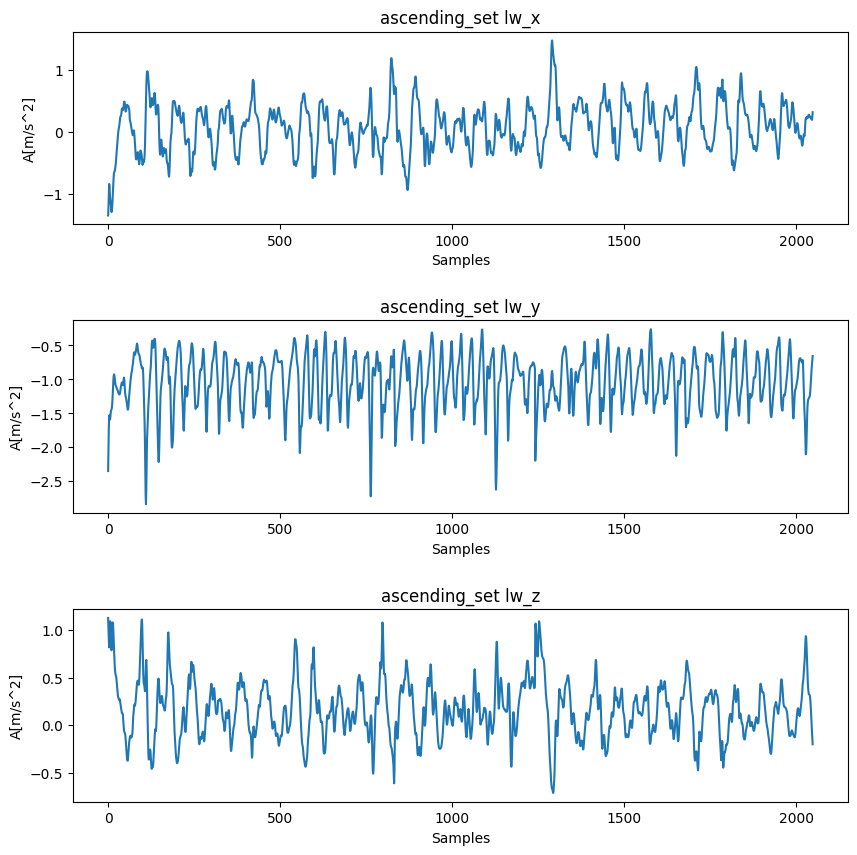

In [ ]:
Data = "ascending_set" #@param ['walking_set', 'ascending_set', 'discending_set']
Accelerometers = "lw" #@param ['lw', 'lh', 'la', 'ra']


# Create subplots
fig, axs = plt.subplots(3,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)


# Remove duplicate rows based on filename column
df = globals()[Data].drop_duplicates(subset="filename", keep="first")

# Get list of indices where filename changes
indices = df.index.tolist()


# Plot data and vertical lines on each subplot
for i,j in enumerate(["x","y","z"]):
    # Plot data
    axs[i].plot(np.array(globals()[Data][f"{Accelerometers}_{j}"][:2048]))
    axs[i].set_title(Data + " " + Accelerometers + f"_{j}")
    axs[i].set_xlabel('Samples')
    axs[i].set_ylabel('A[m/s^2]')

# Show plot
plt.show()

## Divide in windows

In the following cells, the data are transformed into virtual 2D images and
segment it into fixed-size time windows. These time windows
serve as inputs for testing various architectures in our pipeline.

In [ ]:
window_size = 2048
stride = 2048 # stride is equal to the windows size, so no overlapping

In [ ]:
accelerometers = ["lw_x","lw_y","lw_z","lh_x","lh_y","lh_z","la_x","la_y","la_z","ra_x","ra_y","ra_z"]
# accelerometers = ["ra_x","ra_y","ra_z"] # set this to build the dataset with only specific accelerometers
model_name = "all_sensors"

In [ ]:
test_indices = [2,5,9,14,18,20] # test set, fixed

For every activity we apply the sliding windows segmentation in order to obtain the dataset.

In [ ]:
# Convert numpy array to pandas data frame
df = pd.DataFrame(walking_set)

# Split data frame into groups by filename
groups = df.groupby("filename")

# Create an empty list to store individual measurements
individuals = []

# Loop over groups and extract sub-data frames as numpy arrays
for name, group in groups:
    # Get only the measurement column as a numpy array
    measurement = group[accelerometers].to_numpy()
    # Append the array to the list
    individuals.append(measurement)


test_individuals = [individuals[i] for i in test_indices]
train_individuals = [individuals[i] for i in range(len(individuals)) if i not in test_indices]

# Create an empty list to store sliding windows
train_windows = []
test_windows = []

# training set
# Loop over individual measurements and apply sliding window technique
for individual in train_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    train_windows.extend(window)

# training set
# Loop over individual measurements and apply sliding window technique
for individual in test_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    test_windows.extend(window)


train_walking = (np.array(train_windows))
test_walking = (np.array(test_windows))
print("test_indices",test_indices)
print(train_walking.shape)
print(test_walking.shape)

test_indices [2, 5, 9, 14, 18, 20]
(612, 12, 2048)
(142, 12, 2048)


In [ ]:
# Convert numpy array to pandas data frame
df = pd.DataFrame(ascending_set)

# Split data frame into groups by filename
groups = df.groupby("filename")

# Create an empty list to store individual measurements
individuals = []

# Loop over groups and extract sub-data frames as numpy arrays
for name, group in groups:
    # Get only the measurement column as a numpy array
    measurement = group[accelerometers].to_numpy()
    # Append the array to the list
    individuals.append(measurement)


# random_indices = np.random.choice(len(individuals), n_test, replace=False)
test_individuals = [individuals[i] for i in test_indices]
train_individuals = [individuals[i] for i in range(len(individuals)) if i not in test_indices]

# Create an empty list to store sliding windows
train_windows = []
test_windows = []

# training set
# Loop over individual measurements and apply sliding window technique
for individual in train_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    train_windows.extend(window)

# training set
# Loop over individual measurements and apply sliding window technique
for individual in test_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    test_windows.extend(window)


train_ascending = (np.array(train_windows))
test_ascending = (np.array(test_windows))
print(train_ascending.shape)
print(test_ascending.shape)

(91, 12, 2048)
(21, 12, 2048)


In [ ]:
# Convert numpy array to pandas data frame
df = pd.DataFrame(discending_set)

# Split data frame into groups by filename
groups = df.groupby("filename")

# Create an empty list to store individual measurements
individuals = []

# Loop over groups and extract sub-data frames as numpy arrays
for name, group in groups:
    # Get only the measurement column as a numpy array
    measurement = group[accelerometers].to_numpy()
    # Append the array to the list
    individuals.append(measurement)


# random_indices = np.random.choice(len(individuals), n_test, replace=False)
test_individuals = [individuals[i] for i in test_indices]
train_individuals = [individuals[i] for i in range(len(individuals)) if i not in test_indices]

# Create an empty list to store sliding windows
train_windows = []
test_windows = []

# training set
# Loop over individual measurements and apply sliding window technique
for individual in train_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    train_windows.extend(window)

# training set
# Loop over individual measurements and apply sliding window technique
for individual in test_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    test_windows.extend(window)


train_discending = (np.array(train_windows))
test_discending = (np.array(test_windows))
print(train_discending.shape)
print(test_discending.shape)

(100, 12, 2048)
(23, 12, 2048)


We visualize an example of input data, reshaped in a 2D image.

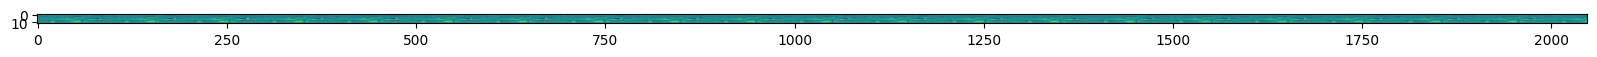

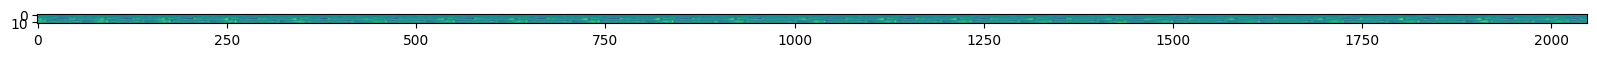

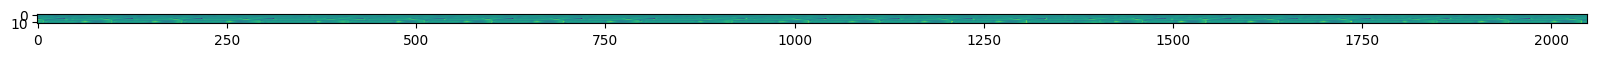

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(20, 40)
plt.imshow(train_walking[0])
plt.show()
fig = plt.gcf()
fig.set_size_inches(20, 40)
plt.imshow(train_ascending[0])
plt.show()
fig = plt.gcf()
fig.set_size_inches(20, 40)
plt.imshow(train_discending[0])
plt.show()

Build train and test set.

In [ ]:
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Determine the minimum number of samples available in each class in the training and test datasets
max_train = np.min([len(train_walking),len(train_ascending),len(train_discending)])
max_test = np.min([len(test_walking),len(test_ascending),len(test_discending)])

# Concatenate the data from different classes in both training and test datasets, this balances the number of samples in each class
X_train = np.concatenate([train_walking[:max_train], train_ascending[:max_train], train_discending[:max_train]], axis=0)
X_test = np.concatenate([test_walking[:max_test], test_ascending[:max_test], test_discending[:max_test]], axis=0)

# Create labels for the training and test data, representing the classes (0 for walking, 1 for ascending, 2 for descending)
y_train = np.repeat([0, 1, 2], [max_train, max_train, max_train])
# Shuffle the training data and labels, ensuring randomness and preventing any order bias
X_train, y_train = shuffle(X_train, y_train, random_state=100)
y_train = keras.utils.to_categorical(y_train)
# Same operations for test set
y_test = (np.repeat([0, 1, 2], [max_test, max_test, max_test]))
X_test, y_test = shuffle(X_test, y_test,random_state=100)
y_test = keras.utils.to_categorical(y_test)

print(X_train.shape)
print(X_test.shape)

(273, 12, 2048)
(63, 12, 2048)


Now we will try the different models on the dataset.

## LSTM

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Import Keras and other libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import numpy as np


# Define the RNN model
model = Sequential()
model.add(LSTM(1024, input_shape=(12, 2048),return_sequences=True)) # input_shape must be equal to the window_size
model.add(LSTM(512))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train the model
path = "/content/gdrive/MyDrive/HDA/lstm/"+ model_name + "/best_model.ckpt"
checkpoint = ModelCheckpoint(path, monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=500,validation_data=(X_test, y_test), callbacks = [checkpoint])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 1024)          12587008  
                                                                 
 lstm_3 (LSTM)               (None, 512)               3147776   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 15736323 (60.03 MB)
Trainable params: 15736323 (60.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.1063 - accuracy: 0.3553
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to /content/gdrive/MyDrive/HDA/lstm/all_sensors/best_model.ckpt
1/1 [==============================] - 10s 10s/step -

In [ ]:
# Load the weights from the checkpoint files

model.load_weights(path)
y_pred = model.predict(X_test)
evaluate_metrics(y_pred.argmax(axis=1),y_test.argmax(axis=1))

ValueError: ignored

## Simple transformer

Standard transformer implementation, used as a benchmark against the SCvT model.

In [ ]:
from tensorflow.keras import layers

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
y_train_cat = y_train.argmax(axis=1)
y_test_cat = y_test.argmax(axis=1)

n_classes = 3

In [ ]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()
path = "/content/gdrive/MyDrive/HDA/simple_transformer/"+ model_name + "/best_model.ckpt"

checkpoint = ModelCheckpoint(path, monitor="val_sparse_categorical_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)

model.fit(
    X_train,
    y_train_cat,
    validation_data = (X_test, y_test_cat),
    epochs=100,
    batch_size=100,
    callbacks=[checkpoint],
)

model.evaluate(X_test, y_test_cat, verbose=1)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 2048)]           0         []                            
                                                                                                  
 layer_normalization_36 (La  (None, 12, 2048)             4096      ['input_1[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_18 (M  (None, 12, 2048)             8393728   ['layer_normalization_36[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_36

[1.2277456521987915, 0.380952388048172]

In [ ]:
model.load_weights(path)
y_pred = model.predict(X_test)
evaluate_metrics(y_pred.argmax(axis=1),y_test.argmax(axis=1))

18/18 [==============================] - 1s 10ms/step
Accuracy: 0.5245614035087719
Precision: [0.67114094 0.43312102 0.58878505]
Precision (weighted): 0.5643490018115226
Recall: [0.52631579 0.71578947 0.33157895]
Recall (weighted): 0.5245614035087719
F1: [0.5899705  0.53968254 0.42424242]
F1 (weighted): 0.5179651551332968


## CNN

In [ ]:
# Define the CNN model with a bigger architecture
model = keras.Sequential()
model.add(keras.layers.Conv2D(512, (12, 12), strides=(1,1), activation='relu', input_shape=(12, 2048, 1), padding="same")) # input_shape must be equal to the window_size
model.add(keras.layers.MaxPool2D((12, 12),strides=(1,1)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv2D(256, (4,4), strides=(1, 1), activation='relu', padding="same"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


In [ ]:
path = "/content/gdrive/MyDrive/HDA/cnn/"+ model_name + "/best_model.ckpt"
checkpoint = ModelCheckpoint(path, monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=50, epochs=100, validation_data=(X_test, y_test), callbacks = [checkpoint]) # Reduce batch_size to 50 when running with window_Size = 2048, otherwise you get an error due to GPU RAM saturation

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.3408 - accuracy: 0.3956
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/gdrive/MyDrive/HDA/cnn/all_sensors/best_model.ckpt
6/6 [==============================] - 30s 3s/step - loss: 1.3408 - accuracy: 0.3956 - val_loss: 1.0927 - val_accuracy: 0.3333
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.1019 - accuracy: 0.3370
Epoch 2: val_accuracy did not improve from 0.33333
6/6 [==============================] - 5s 792ms/step - loss: 1.1019 - accuracy: 0.3370 - val_loss: 1.0960 - val_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 1.0887 - accuracy: 0.3883
Epoch 3: val_accuracy did not improve from 0.33333
6/6 [==============================] - 5s 797ms/step - loss: 1.0887 - accuracy: 0.3883 - val_loss: 1.0809 - val_accuracy: 0.3333
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 1.0707 - accuracy: 0.3516
Epoch 4: val

In [ ]:
# Load the weights from the checkpoint files
model.load_weights(path)
y_pred = model.predict(X_test)
evaluate_metrics(y_pred.argmax(axis=1),y_test.argmax(axis=1))

18/18 [==============================] - 0s 22ms/step
Accuracy: 0.8210526315789474
Precision: [0.97916667 0.6584507  0.9893617 ]
Precision (weighted): 0.8756596910065594
Recall: [0.98947368 0.98421053 0.48947368]
Recall (weighted): 0.8210526315789474
F1: [0.98429319 0.78902954 0.65492958]
F1 (weighted): 0.8094174356823483


## SCvT

This is the model based on Convolutional Transformer, our model of interest.

In [ ]:
!pip install einops

In [ ]:
import tensorflow as tf
import einops

In [ ]:
def load_data(batch_size, X_train, X_test, y_train, y_test):
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2],X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2],X_test.shape[1]))

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    # train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed = 100)
    train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

    return train_dataset, test_dataset

ds_train, ds_test = load_data(50, X_train, X_test, y_train, y_test)

In [ ]:
ds_train.element_spec

(TensorSpec(shape=(None, 2048, 12), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))

In [ ]:
from einops.layers.tensorflow import Rearrange

class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(AttentionBlock, self).__init__()

        # Multi head attention layers
        self.att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim)

        # Dense layers
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation=tf.keras.activations.gelu),
            tf.keras.layers.Dense(embed_dim)]
        )

        # Some layer normalization and Dropout
        self.layernorm_a = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_b = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout_a = tf.keras.layers.Dropout(dropout)
        self.dropout_b = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_a(attn_output,training=training)
        out_a = self.layernorm_a(inputs + attn_output)
        ffn_output = self.ffn(out_a)
        ffn_output = self.dropout_b(ffn_output,training=training)
        return self.layernorm_b(out_a + ffn_output)

class SCvT(tf.keras.Model):
    def __init__(
        self,
        num_layers,
        num_classes,
        d_model,
        num_heads,
        mlp_dim,
        dropout,
    ):
        super(SCvT, self).__init__()

        self.d_model = d_model

        # Positional embeddings
        self.pos_emb = self.add_weight("pos_emb",
             shape=(1, 5, d_model))

        # Class embedding (for classification)
        self.class_emb = self.add_weight("class_emb",
            shape=(1, 1, d_model))

        # Projection layer
        self.projection = tf.keras.layers.Dense(d_model)

        # Convolutional layer
        self.convolution = ConvolutionBlock()

        # Attention layer
        self.enc_layers = [
            AttentionBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]

        # MLP head for classification
        self.mlp_head = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(mlp_dim,
                    activation=tf.keras.activations.gelu),
                tf.keras.layers.Dense(num_classes),
            ]
        )

    def call(self, input, training):

        input = Rearrange("b w c -> b c w 1")(input)
        activations = self.convolution(input) # Convolution
        activations = Rearrange("b w h f -> b w (h f)")(activations)
        batch_size = tf.shape(input)[0]

        x = self.projection(activations) # Projection layer

        class_emb = tf.broadcast_to(self.class_emb,
            [batch_size, 1, self.d_model])

        # Residual connections
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb

        # Attention layers
        for layer in self.enc_layers:
            x = layer(x, training)

        return self.mlp_head(x[:, 0])

In [ ]:
# Define a custom Keras layer called ConvolutionBlock for building a specific convolutional feature extraction block
class ConvolutionBlock(tf.keras.layers.Layer):
    def __init__(
        self,
    ):
        super(ConvolutionBlock, self).__init__()

        self.conv_layers = tf.keras.Sequential(
                    [
                        # First Convolutional layer with 50 filters, [3x24] kernel and ReLU activation.
                        tf.keras.layers.Conv2D(
                            50,
                            kernel_size=[3,24],
                            strides=[1,1],
                            padding="same",
                            data_format="channels_last",
                            use_bias=False,
                        ),
                        tf.keras.layers.ReLU(),
                        tf.keras.layers.MaxPool2D(
                            pool_size=12,
                            strides=3,
                            padding="same"
                        ),
                        # Second Convolutional layer with 25 filters, [4x24] kernel and ReLU activation.
                        tf.keras.layers.Conv2D(
                            25,
                            kernel_size=[4,24],
                            strides=[1,1],
                            padding="same",
                            data_format="channels_last",
                            use_bias=False,
                        ),
                        tf.keras.layers.ReLU(),
                    ]

        )

    # Implement the call method to define the forward pass
    def call(self, x):
        x = self.conv_layers(x)
        return x

In [ ]:
%cd /content/gdrive/MyDrive/HDA/

/content/gdrive/.shortcut-targets-by-id/1tU_b3zqW_OmhMosRd3VHHxp5cNNbFZM6/HDA


In [ ]:
from tensorflow.python.eager import context
import random
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def set_global_determinism(seed):


    context._context = None
    context._create_context()
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
# set_global_determinism(seed=100)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
set_global_determinism(seed=20)
model = SCvT(
        num_classes=3,
        num_layers=2,
        d_model=32,
        num_heads=2,
        mlp_dim=128,
        dropout=0.5,
)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
      metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
    ]
)
path = "/content/gdrive/MyDrive/HDA/SCvT/"+ model_name + "/best_model.ckpt"
checkpoint = ModelCheckpoint(path, monitor="val_categorical_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)

model.fit(ds_train, validation_data=ds_test, epochs=100, verbose=1, callbacks=[checkpoint])

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.1369 - categorical_accuracy: 0.3370
Epoch 1: val_categorical_accuracy improved from -inf to 0.42857, saving model to /content/gdrive/MyDrive/HDA/SCvT/all_sensors/best_model.ckpt
6/6 [==============================] - 29s 246ms/step - loss: 1.1369 - categorical_accuracy: 0.3370 - val_loss: 1.0888 - val_categorical_accuracy: 0.4286
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.1266 - categorical_accuracy: 0.3407
Epoch 2: val_categorical_accuracy improved from 0.42857 to 0.53968, saving model to /content/gdrive/MyDrive/HDA/SCvT/all_sensors/best_model.ckpt
6/6 [==============================] - 1s 163ms/step - loss: 1.1266 - categorical_accuracy: 0.3407 - val_loss: 1.0693 - val_categorical_accuracy: 0.5397
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 1.0757 - categorical_accuracy: 0.4469
Epoch 3: val_categorical_accuracy improved from 0.53968 to 0.61905, saving model to /conten

In [ ]:
# Load the weights from the checkpoint files
path = "/content/gdrive/MyDrive/HDA/SCvT/"+ model_name + "/best_model.ckpt"

model.load_weights(path)
y_pred = model.predict(ds_test)
evaluate_metrics(y_pred.argmax(axis=1),y_test.argmax(axis=1))

2/2 [==============================] - 0s 28ms/step
Accuracy: 1.0
Precision: [1. 1. 1.]
Precision (weighted): 1.0
Recall: [1. 1. 1.]
Recall (weighted): 1.0
F1: [1. 1. 1.]
F1 (weighted): 1.0


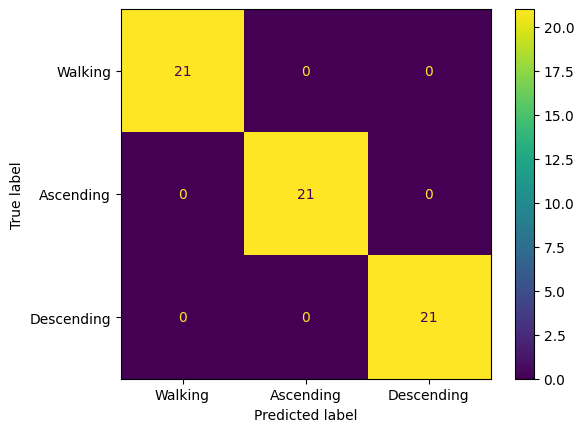

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_pred ]
cm = confusion_matrix(y_test_non_category, y_predict_non_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Walking', 'Ascending', 'Descending'])
disp.plot()
plt.show()

###Visualize layers

The objective of this part of work is to enhance the interpretability of the model and gain valuable insights into the significance of various features. A key aspect of our research is to determine the accelerometers that contribute the most informative data regarding an individual's activities. In simpler terms, we aim to identify the optimal placement for an accelerometer to effectively recognize activities, thereby reducing the overall costs associated with using multiple recording devices.
To achieve this goal, we initially trained the model using a dataset that includes data from four accelerometers. Subsequently, we performed an analysis of the convolutional layers and the projection layer.

In [ ]:
X_test_reshaped = np.copy(X_test)
X_test_reshaped = X_test_reshaped.reshape((X_test.shape[0],X_test.shape[2],X_test.shape[1]))

Here we load the intermediate convolutional layer with respectively the input and output of each consecutive layer.

In [ ]:
intermediate_models = []
for layer in model.convolution.conv_layers.layers:
    intermediate_model = tf.keras.Model(inputs=model.convolution.conv_layers.input, outputs=layer.output)
    intermediate_models.append(intermediate_model)

In [ ]:
def print_image(name, images, num=6):
  if name == "Weights":
    fig, axs = plt.subplots(1, num, figsize=(12, 4))
    for i in range(num):
      axs[i].imshow(images[:,:,0,i], cmap='viridis')
      axs[i].set_title(name + " " + str(i))
      axs[i].axis('off')
    plt.show()
  else:
    fig, axs = plt.subplots(num, 1, figsize=(12, 6))
    for i in range(num):
      axs[i].imshow(images[0,:,:,i][:,:200], cmap='viridis')
      axs[i].set_title(name + " " + str(i))
      axs[i].axis('off')
    plt.show()

In [ ]:
# Function to print information about layers, including weights and activations.
def print_layers(X_test,y_test,example_ind):
  for i, intermediate_model in enumerate(intermediate_models):
      print(y_test[example_ind])
      print(f"Layer {i}: {intermediate_model.layers[-1].name}")
      if len(intermediate_model.layers[-1].get_weights()) > 0:
        print(f"Weights: {intermediate_model.layers[-1].get_weights()[0].shape}")
        print_image("Weights",intermediate_model.layers[-1].get_weights()[0])
      print(f"Activations: {intermediate_model.predict(X_test).shape}")
      print_image("Activations",intermediate_model.predict(X_test[:,:,:]))

This function plots 5 different figures:
- Figure 1 below presents a visual representation of kernel weights
obtained during the model training phase. In the context of
image data, an examination of these kernels can give valuable
insights into the model’s learning process. Each kernel is
responsible for detecting specific visual patterns, including
edges, textures, shapes, or more complex structures, depending
on the network’s architecture and training dataset. Over the
course of training, the network fine-tunes these kernel values
to gain features critical for accurate classification or detection
tasks.

- Figure 2 illustrates how the kernel activations manifest in the
training data. All activations are cropped to a width of 200 for
improved visualization.

- Figure 3 showcases the same activations
respectively before and after passing through the ReLU func-
tion, which effectively sets negative values to zero, making
it easier to identify regions of increased activation (indicated
by lighter-colored pixels). This helps in detecting the areas
that provide more information for classification. It becomes
evident through visual inspection that most significant features
are concentrated in the lower channels of the activation map.

- Figure 5 the activation has undergone processing with
a max-pooling layer using a stride of three. This pooling is
performed to consolidate information from each axis of the ac-
celerometers (x, y, z) and condense the information from each
accelerometer into one row.

[0. 1. 0.]
Layer 0: conv2d_18
Weights: (3, 24, 1, 50)


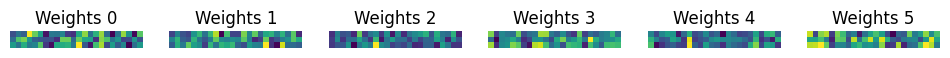

2/2 [==============================] - 0s 8ms/step
Activations: (63, 12, 2048, 50)
2/2 [==============================] - 0s 6ms/step


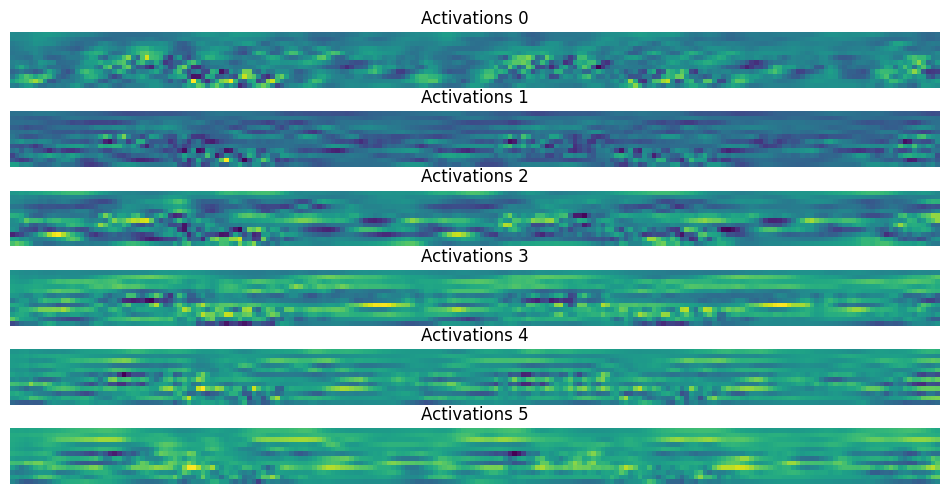

[0. 1. 0.]
Layer 1: re_lu_18
2/2 [==============================] - 0s 10ms/step
Activations: (63, 12, 2048, 50)
2/2 [==============================] - 0s 10ms/step


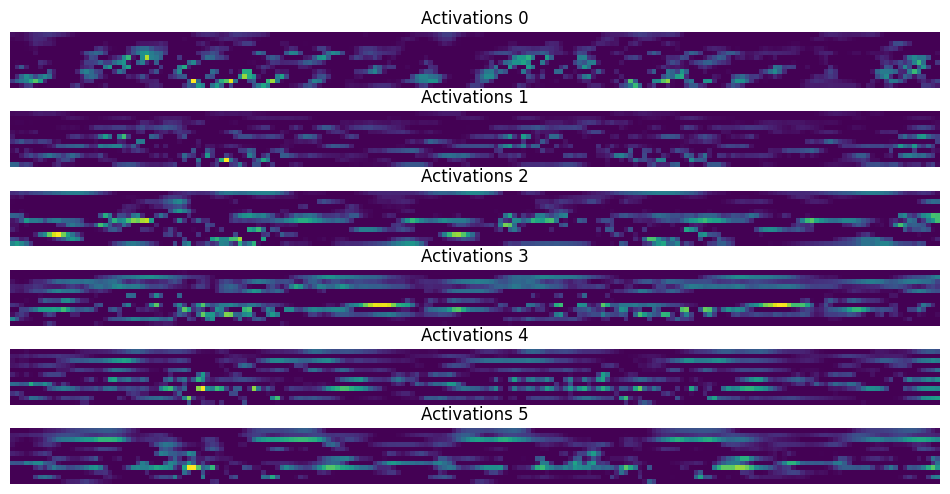

[0. 1. 0.]
Layer 2: max_pooling2d_9
2/2 [==============================] - 0s 8ms/step
Activations: (63, 4, 683, 50)
2/2 [==============================] - 0s 9ms/step


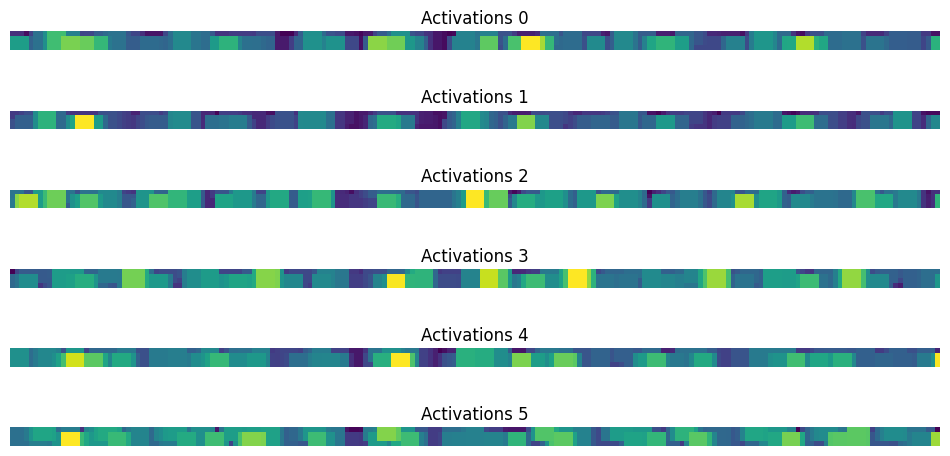

[0. 1. 0.]
Layer 3: conv2d_19
Weights: (4, 24, 50, 25)


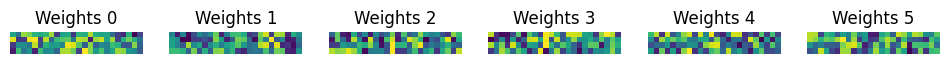

2/2 [==============================] - 0s 24ms/step
Activations: (63, 4, 683, 25)
2/2 [==============================] - 0s 24ms/step


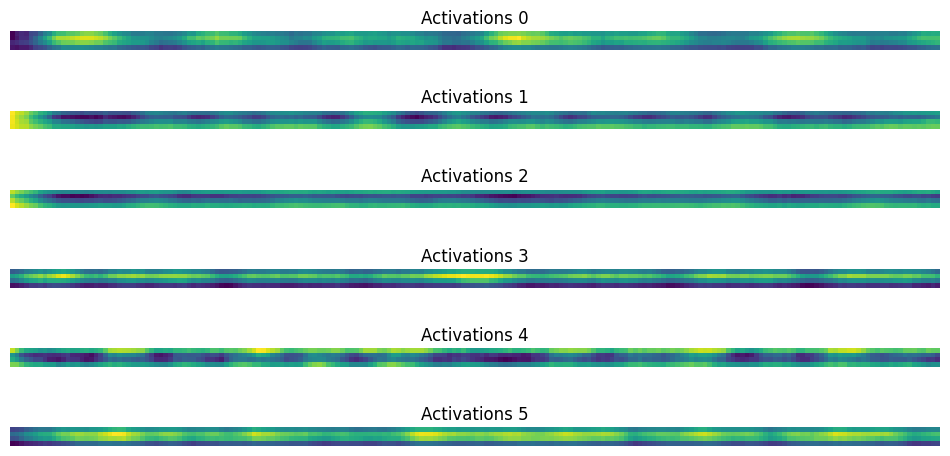

[0. 1. 0.]
Layer 4: re_lu_19
2/2 [==============================] - 0s 23ms/step
Activations: (63, 4, 683, 25)
2/2 [==============================] - 0s 24ms/step


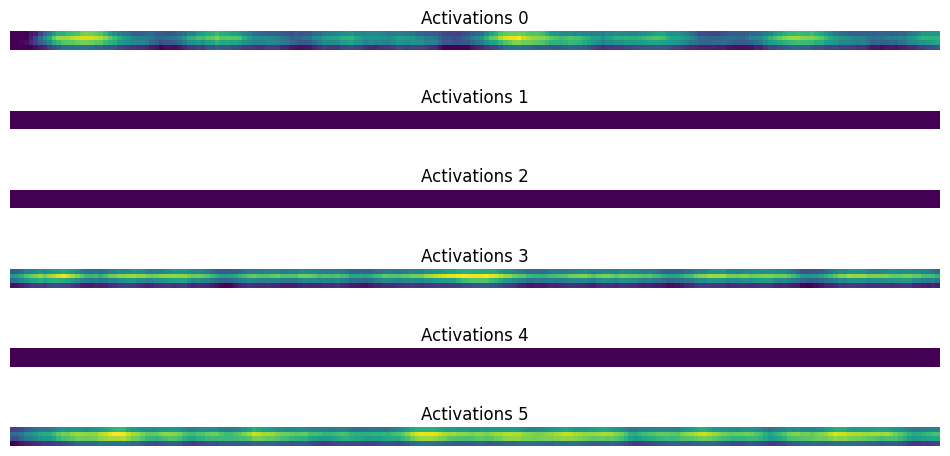

In [ ]:
print_layers(X_test,y_test,0)

This are the results of the cumulative sum as described in the paper.

In [ ]:
layers = intermediate_models[2].predict(X_test)
print(layers.shape)
result = np.sum(layers, axis=(0, 2, 3))
result

2/2 [==============================] - 0s 4ms/step
(63, 4, 683, 50)


array([619168.7 , 766944.94, 779720.6 , 766140.3 ], dtype=float32)

### Inspection of Projection layer

Another approach we used to gain insights into the feature
involved an examination of the projection layer subsequent
to the convolutional layer. During this stage, the final activations of the convolutional layer are projected into a reduced dimensional space (specifically, 32 dimensions across 4 channels). Subsequently, these projections are fed into the attention
block.
Post-training, this lower-dimensional space is intended to
function as a summarizer and compressor of the information.
The idea is that, if the training process has effectively engendered meaningful representations of the data, this layer should
offer a concise yet meaningful characterization of our dataset.

This is the whole block of the SCvT, we run it manually from out of the model in order to be able to inspect specific inputs and outputs.

In [ ]:
input = Rearrange("b w c -> b c w 1")(X_test_reshaped)
activations = model.convolution(input)
activations = Rearrange("b w h f -> b w (h f)")(activations)
batch_size = tf.shape(input)[0]
x = model.projection(activations)
data = x # we take the data at this point
class_emb = tf.broadcast_to(model.class_emb,
    [batch_size, 1, model.d_model])
x = tf.concat([class_emb, x], axis=1)
x = x + model.pos_emb
for layer in model.enc_layers:
    x = layer(x, False)
print(model.mlp_head(x[:, 0]))

tf.Tensor(
[[-4.4983864   4.85587    -0.70128536]
 [-3.092778    4.699414   -2.6765351 ]
 [ 4.810212   -3.407891   -2.8126178 ]
 [-2.5062196  -2.812309    4.273847  ]
 [-1.3166395  -3.1050103   3.2931874 ]
 [-3.0287387   4.6582775  -2.6469991 ]
 [-3.1429343   4.7233887  -2.6201518 ]
 [ 4.3975077  -2.6788788  -2.987705  ]
 [ 4.3137417  -3.1038022  -2.455365  ]
 [-2.9070108  -2.5428824   4.618005  ]
 [ 4.508568   -2.8572211  -3.0733473 ]
 [ 4.7170734  -3.2024338  -2.9539108 ]
 [ 4.698041   -3.5242002  -2.519461  ]
 [-2.2999425  -2.868174    4.077849  ]
 [-4.4763355   4.8961225  -0.77704346]
 [-3.2005856   4.7773013  -2.592179  ]
 [-3.399214    4.66898    -2.0182593 ]
 [-1.4387467  -3.0580661   3.4268777 ]
 [ 4.556465   -2.9361072  -3.0491588 ]
 [-3.0515726  -2.521306    4.697672  ]
 [-3.6713767  -1.8419164   4.9816265 ]
 [-2.9068258  -2.6190605   4.6106267 ]
 [-0.75682664  2.7455435  -3.3467686 ]
 [-3.476384   -2.1380973   4.9440193 ]
 [-2.2655718  -2.8731575   4.1270914 ]
 [-4.119776   

In [ ]:
y_test.shape
y_labels = np.argmax(y_test, axis=1)

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=2614a8e5611e99c35c1a6cbeb24d3e2de58aca36045ff60de65eb0afc05772e3
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=4bf352953565543b45313dba57e4f386bdc016318f78de44ef83b936c4374df7
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


Here are the visualization after compressing the output of the projection layer in 2D. We used PCA, TSNE and UMAP.

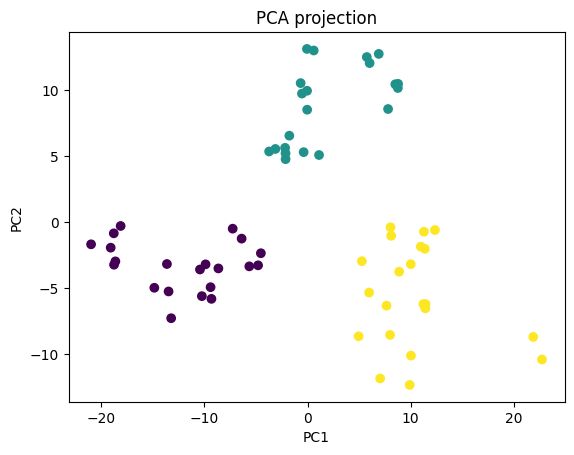

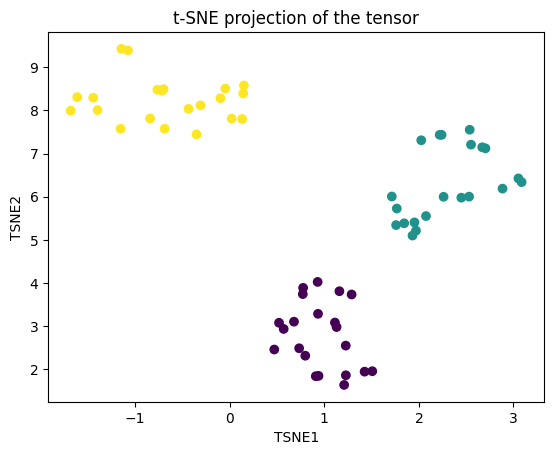

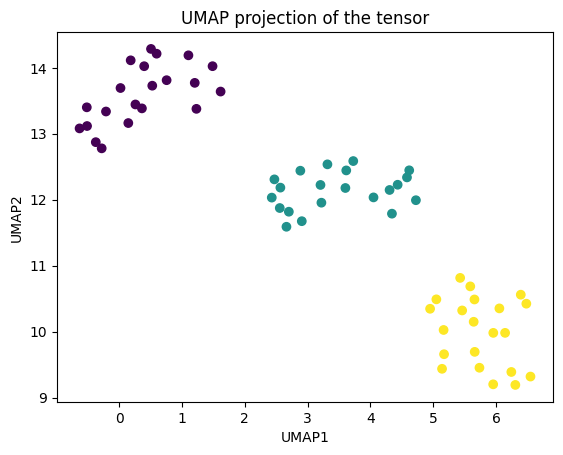

In [ ]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Reshape the tensor into a 2D array with shape (x, y*z)
data_2d = tf.reshape(data, (data.shape[0], -1))
# data_2d = data[:,3,:]

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_2d)

# Plot the projected data on a scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection')
plt.savefig('/content/pca.pdf')
plt.show()


# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data_2d)

# Plot the projected data on a scatter plot
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=y_labels)
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('t-SNE projection of the tensor')
plt.show()


umap_ = umap.UMAP(n_components=2, n_neighbors=50)
data_umap = umap_.fit_transform(data_2d)

# Plot the projected data on a scatter plot
plt.scatter(data_umap[:, 0], data_umap[:, 1], c=y_labels)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP projection of the tensor')
plt.show()

 It is evident from the visualization that PCA
organizes the data into three distinct clusters, each corre-
sponding to one of the three classes. The visible separation
between these clusters signifies that the network has learned
a meaningful compression

Figure below demonstrates the application of PCA to the raw test set,
wherein no significant separation is observed. This serves as
evidence supporting the assertion that the projection layer has
indeed contributed to the meaningful characterization of the
data.

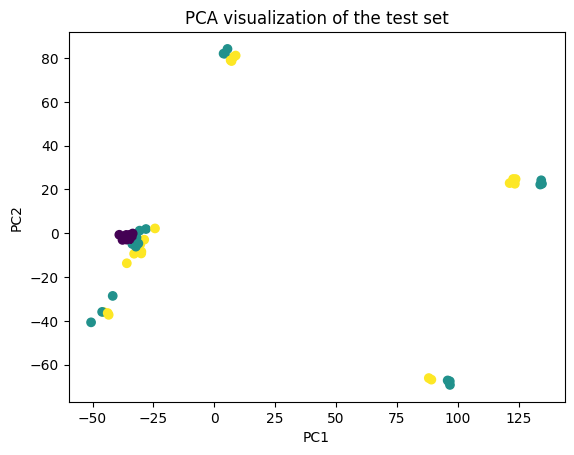

In [ ]:
# Reshape the tensor into a 2D array with shape (x, y*z)
data_2d = tf.reshape(X_test_reshaped, (X_test_reshaped.shape[0], -1)) # All the accelerometers
# data_2d = data[:,3,:] # Modify this and set a different integer value to select a specific accelerometer

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_2d)

# Plot the projected data on a scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA visualization of the test set')
plt.savefig('/content/pca_raw.pdf')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

In order to assess the relative contributions of each accelerometer, a K-means clustering method was employed to cluster the (32x4) vectors in an unsupervised manner. Given that each of the four vectors encapsulates information from
a distinct accelerometer, we individually presented each of the four 32-dimensional vectors to the K-means algorithm. The underlying idea is that the ease with which K-means accurately clusters these vectors with respect to the ground truth label indicates the significance of each accelerometer’s
contribution.

In [ ]:
data_2d = tf.reshape(data, (data.shape[0], -1))

kmeans = KMeans(n_clusters=3)
kmeans.fit(data_2d)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
labels

array([0, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0,
       2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0,
       2, 1, 0, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 0, 2, 2, 1, 2, 1],
      dtype=int32)

The following block needs to be set manually every time we run K-means, because it returns label in different order than we expect.

In [ ]:
swap_dict = {0: 1, 1: 0, 2: 2} # Define a dictionary that maps the old labels to the new ones
swap_func = np.vectorize(lambda x: swap_dict[x]) # Define a vectorized function that applies the dictionary to each element
new_labels = swap_func(labels) # Apply the function to the labels array and get the new labels

In [ ]:
new_labels

array([1, 2, 2, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 0, 0, 1,
       2, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 0, 2, 0])

In [ ]:
y_labels

array([1, 2, 2, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 0, 0, 1,
       2, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 0, 2, 0])

This are the results after using each si

In [ ]:
evaluate_metrics(new_labels, y_labels) # all, attention

Accuracy: 1.0
Precision: [1. 1. 1.]
Precision (weighted): 1.0
Recall: [1. 1. 1.]
Recall (weighted): 1.0
F1: [1. 1. 1.]
F1 (weighted): 1.0


In [ ]:
evaluate_metrics(new_labels, y_labels) # 1

Accuracy: 0.9523809523809523
Precision: [0.95454545 0.90909091 1.        ]
Precision (weighted): 0.9545454545454546
Recall: [1.         0.95238095 0.9047619 ]
Recall (weighted): 0.9523809523809523
F1: [0.97674419 0.93023256 0.95      ]
F1 (weighted): 0.952325581395349


In [ ]:
evaluate_metrics(new_labels, y_labels) # 2

Accuracy: 0.9682539682539683
Precision: [0.95454545 0.95238095 1.        ]
Precision (weighted): 0.968975468975469
Recall: [1.         0.95238095 0.95238095]
Recall (weighted): 0.9682539682539683
F1: [0.97674419 0.95238095 0.97560976]
F1 (weighted): 0.9682449648416749


In [ ]:
evaluate_metrics(new_labels, y_labels) # 3

Accuracy: 0.9682539682539683
Precision: [0.95454545 0.95238095 1.        ]
Precision (weighted): 0.968975468975469
Recall: [1.         0.95238095 0.95238095]
Recall (weighted): 0.9682539682539683
F1: [0.97674419 0.95238095 0.97560976]
F1 (weighted): 0.9682449648416749


In [ ]:
evaluate_metrics(new_labels, y_labels) # 4

Accuracy: 0.9682539682539683
Precision: [0.95454545 0.95238095 1.        ]
Precision (weighted): 0.968975468975469
Recall: [1.         0.95238095 0.95238095]
Recall (weighted): 0.9682539682539683
F1: [0.97674419 0.95238095 0.97560976]
F1 (weighted): 0.9682449648416749


# TEST
This section collects the test phase, in the following cells, valuation phase were carried out for all models with window size = 256 and 2048.

In [ ]:
def createDataset():
    #Create Dataset containing all csv
    path = '/content/gdrive/MyDrive/HDA/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data'
    all_files = glob.glob(os.path.join(path, "*.csv"))

    # Create an empty list to store DataFrames
    dataframes = []

    # Loop over the files
    for file in all_files:
        # Read the file as a DataFrame and add a filename column
        filename = file.replace("/content/gdrive/MyDrive/HDA/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/","")
        df = pd.read_csv(file).assign(filename=filename)
        # Append the DataFrame to the list
        dataframes.append(df)

    # Concatenate all the DataFrames into one
    dataset = pd.concat(dataframes, ignore_index=True)


    #Delete the useless value (activities that are not been studied)
    activities_99 = dataset[dataset.activity == 99]
    activities_77 = dataset[dataset.activity == 77]
    activities_4 = dataset[dataset.activity == 4]
    print('Number of activities not studied removed:\n', ' - Activities 99:', len(activities_99), '\n  - Activities 4:',len(activities_4), '\n  - Activities 77:',len(activities_77))
    dataset = dataset[(dataset.activity != 99) & (dataset.activity != 4) & (dataset.activity != 77)]
    #Divide the activities in 3 different dataset in order to analyze them separatly
    walking_set = dataset[dataset.activity == 1]
    ascending_set = dataset[dataset.activity == 2]
    discending_set = dataset[dataset.activity == 3]

    #Split Dataset into Train/Val and Test set
    train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
    train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.2)
    walking_set = walking_set.reset_index()
    ascending_set = ascending_set.reset_index()
    discending_set = discending_set.reset_index()

    return walking_set, ascending_set, discending_set

walking_set, ascending_set, discending_set = createDataset()

# print('Number of activities studied:', len(dataset))
print('Number of walking (=1) activities:', len(walking_set))
print('Number of descending stairs (=2) activities:', len(ascending_set))
print('Number of ascending stairs (=3) activities:', len(discending_set))

Number of activities not studied removed:
  - Activities 99: 3193794 
  - Activities 4: 3741501 
  - Activities 77: 122515
Number of walking (=1) activities: 1576845
Number of descending stairs (=2) activities: 267538
Number of ascending stairs (=3) activities: 279907


In [ ]:
random_indices_validation = [3,6,15,19] # validation set
random_indices = [2,5,9,14,18,20] # test set

# Convert numpy array to pandas data frame
df = pd.DataFrame(walking_set)

# Split data frame into groups by filename
groups = df.groupby("filename")

# Create an empty list to store individual measurements
individuals = []

# Loop over groups and extract sub-data frames as numpy arrays
for name, group in groups:
    # Get only the measurement column as a numpy array
    measurement = group[accelerometers].to_numpy()
    # Append the array to the list
    individuals.append(measurement)

test_individuals = [individuals[i] for i in random_indices]
validation_individuals = [individuals[i] for i in random_indices_validation]
train_individuals = [individuals[i] for i in range(len(individuals)) if i not in random_indices and i not in random_indices_validation]

# Create an empty list to store sliding windows
validation_windows = []
train_windows = []
test_windows = []

# training set
# Loop over individual measurements and apply sliding window technique
for individual in train_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    train_windows.extend(window)

# training set
# Loop over individual measurements and apply sliding window technique
for individual in test_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    test_windows.extend(window)

# validation set
# Loop over individual measurements and apply sliding window technique
for individual in validation_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    validation_windows.extend(window)

train_walking = (np.array(train_windows))
validation_walking = (np.array(validation_windows))
test_walking = (np.array(test_windows))
print("random_indices test",random_indices)
print("random_indices validation",random_indices_validation)
print("Train set dimension: ", train_walking.shape)
print("Validation set dimension: ", validation_walking.shape)
print("Test set dimension: ", test_walking.shape)

random_indices test [2, 5, 9, 14, 18, 20]
random_indices validation [3, 6, 15, 19]
Train set dimension:  (513, 12, 2048)
Validation set dimension:  (99, 12, 2048)
Test set dimension:  (142, 12, 2048)


In [ ]:
# Convert numpy array to pandas data frame
df = pd.DataFrame(ascending_set)

# Split data frame into groups by filename
groups = df.groupby("filename")

# Create an empty list to store individual measurements
individuals = []

# Loop over groups and extract sub-data frames as numpy arrays
for name, group in groups:
    # Get only the measurement column as a numpy array
    measurement = group[accelerometers].to_numpy()
    # Append the array to the list
    individuals.append(measurement)

test_individuals = [individuals[i] for i in random_indices]
validation_individuals = [individuals[i] for i in random_indices_validation]
train_individuals = [individuals[i] for i in range(len(individuals)) if (i not in random_indices and i not in random_indices_validation)]

# Create an empty list to store sliding windows
train_windows = []
validation_windows = []
test_windows = []

# training set
# Loop over individual measurements and apply sliding window technique
for individual in train_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]
    # print(window.shape)

    # Append the window view to the list
    train_windows.extend(window)

# training set
# Loop over individual measurements and apply sliding window technique
for individual in test_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    test_windows.extend(window)

# validation set
# Loop over individual measurements and apply sliding window technique
for individual in validation_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    validation_windows.extend(window)


train_ascending = (np.array(train_windows))
validation_ascending = (np.array(validation_windows))
test_ascending = (np.array(test_windows))
print("Train set dimension: ", train_ascending.shape)
print("Validation set dimension: ", validation_ascending.shape)
print("Test set dimension: ", test_ascending.shape)

Train set dimension:  (75, 12, 2048)
Validation set dimension:  (16, 12, 2048)
Test set dimension:  (21, 12, 2048)


In [ ]:
# Convert numpy array to pandas data frame
df = pd.DataFrame(discending_set)

# Split data frame into groups by filename
groups = df.groupby("filename")

# Create an empty list to store individual measurements
individuals = []

# Loop over groups and extract sub-data frames as numpy arrays
for name, group in groups:
    # Get only the measurement column as a numpy array
    measurement = group[accelerometers].to_numpy()
    # Append the array to the list
    individuals.append(measurement)

test_individuals = [individuals[i] for i in random_indices]
validation_individuals = [individuals[i] for i in random_indices_validation]
train_individuals = [individuals[i] for i in range(len(individuals)) if i not in random_indices and i not in random_indices_validation]

# Create an empty list to store sliding windows
train_windows = []
validation_windows = []
test_windows = []

# training set
# Loop over individual measurements and apply sliding window technique
for individual in train_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    train_windows.extend(window)

# training set
# Loop over individual measurements and apply sliding window technique
for individual in test_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    test_windows.extend(window)

# validation set
# Loop over individual measurements and apply sliding window technique
for individual in validation_individuals:
    # Get sliding window view of individual measurement

    # Apply sliding window technique to individual array
    window = np.lib.stride_tricks.sliding_window_view(individual, window_shape=window_size, axis=0)[::stride]

    # Append the window view to the list
    validation_windows.extend(window)


train_discending = (np.array(train_windows))
validation_discending = (np.array(validation_windows))
test_discending = (np.array(test_windows))
print("Train set dimension: ", train_discending.shape)
print("Validation set dimension: ", validation_discending.shape)
print("Test set dimension: ", test_discending.shape)

Train set dimension:  (83, 12, 2048)
Validation set dimension:  (17, 12, 2048)
Test set dimension:  (23, 12, 2048)


In [ ]:
max_train = np.min([len(train_walking),len(train_ascending),len(train_discending)])
max_validation = np.min([len(validation_walking),len(validation_ascending),len(validation_discending)])
max_test = np.min([len(test_walking),len(test_ascending),len(test_discending)])

X_train = np.concatenate([train_walking[:max_train], train_ascending[:max_train], train_discending[:max_train]], axis=0)
X_validation = np.concatenate([validation_walking[:max_validation], validation_ascending[:max_validation], validation_discending[:max_validation]], axis=0)
X_test = np.concatenate([test_walking[:max_test], test_ascending[:max_test], test_discending[:max_test]], axis=0)

y_train = np.repeat([0, 1, 2], [max_train, max_train, max_train])
X_train, y_train = shuffle(X_train, y_train)
y_train = keras.utils.to_categorical(y_train)
y_validation = np.repeat([0, 1, 2], [max_validation, max_validation, max_validation])
X_validation, y_validation = shuffle(X_validation, y_validation)
y_validation = keras.utils.to_categorical(y_validation)
y_test = (np.repeat([0, 1, 2], [max_test, max_test, max_test]))
X_test, y_test = shuffle(X_test, y_test)
y_test = keras.utils.to_categorical(y_test)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(225, 12, 2048)
(48, 12, 2048)
(63, 12, 2048)


## LSTM

In [ ]:
# Define the RNN model
model_name = 'lstm'
model = Sequential()
model.add(LSTM(1024, input_shape=(12, 2048),return_sequences=True))
model.add(LSTM(512))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train the model
path = "/content/gdrive/MyDrive/HDA/lstm/"+ model_name + "/best_model.ckpt"
checkpoint = ModelCheckpoint(path, monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=500, validation_data=(X_validation, y_validation), callbacks = [checkpoint])

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 1024)          12587008  
                                                                 
 lstm_5 (LSTM)               (None, 512)               3147776   
                                                                 
 dense_68 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 15736323 (60.03 MB)
Trainable params: 15736323 (60.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.1173 - accuracy: 0.3067
Epoch 1: val_accuracy improved from -inf to 0.31250, saving model to /content/gdrive/MyDrive/HDA/lstm/lstm/best_model.ckpt
1/1 [==============================] - 8s 8s/step - loss: 1

In [ ]:
model.load_weights(path)
y_pred = model.predict(X_validation)
evaluate_metrics(y_pred.argmax(axis=1),y_validation.argmax(axis=1))

2/2 [==============================] - 1s 14ms/step
Accuracy: 0.5208333333333334
Precision: [1.         0.36842105 0.54166667]
Precision (weighted): 0.6366959064327485
Recall: [0.3125 0.4375 0.8125]
Recall (weighted): 0.5208333333333334
F1: [0.47619048 0.4        0.65      ]
F1 (weighted): 0.5087301587301587


## CNN

In [ ]:
model_name = 'cnn'
model = keras.Sequential()
model.add(keras.layers.Conv2D(512, (12, 12), strides=(1,1), activation='relu', input_shape=(12, 2048, 1), padding="same"))
model.add(keras.layers.MaxPool2D((12, 12),strides=(1,1)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv2D(256, (4,4), strides=(1, 1), activation='relu', padding="same"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

path = "/content/gdrive/MyDrive/HDA/cnn/"+ model_name + "/best_model.ckpt"
checkpoint = ModelCheckpoint(path, monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, epochs=100, validation_data=(X_validation, y_validation), callbacks = [checkpoint])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.3250 - accuracy: 0.3333
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/gdrive/MyDrive/HDA/cnn/cnn/best_model.ckpt
5/5 [==============================] - 16s 3s/step - loss: 1.3250 - accuracy: 0.3333 - val_loss: 1.1053 - val_accuracy: 0.3333
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.1564 - accuracy: 0.3333
Epoch 2: val_accuracy did not improve from 0.33333
5/5 [==============================] - 4s 734ms/step - loss: 1.1564 - accuracy: 0.3333 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.3333
Epoch 3: val_accuracy did not improve from 0.33333
5/5 [==============================] - 4s 738ms/step - loss: 1.0932 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.3378
Epoch 4: val_accurac

In [ ]:
model.load_weights(path)
y_pred = model.predict(X_validation)
evaluate_metrics(y_pred.argmax(axis=1),y_validation.argmax(axis=1))

2/2 [==============================] - 0s 209ms/step
Accuracy: 0.875
Precision: [1.         0.77777778 0.875     ]
Precision (weighted): 0.8842592592592592
Recall: [0.875 0.875 0.875]
Recall (weighted): 0.875
F1: [0.93333333 0.82352941 0.875     ]
F1 (weighted): 0.8772875816993464


## SCvT

In [ ]:
def load_data(batch_size, X_train, X_validation, X_test, y_train, y_validation, y_test):
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2],X_train.shape[1]))
    X_validation = X_validation.reshape((X_validation.shape[0],X_validation.shape[2],X_validation.shape[1]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2],X_test.shape[1]))

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    # train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed = 100)
    train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)

    validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
    # validation_dataset = validation_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(AUTOTUNE)


    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

    return train_dataset, validation_dataset, test_dataset


ds_train, ds_validation, ds_test = load_data(50, X_train, X_validation, X_test, y_train, y_validation, y_test)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

set_global_determinism(seed=20)

model = SCvT(
        num_classes=3,
        num_layers=2,
        d_model=32,
        num_heads=2,
        mlp_dim=128,
        dropout=0.5,
)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
      metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
    ]
)
model_name = 'scvt'
path = "/content/gdrive/MyDrive/HDA/sensor_transformer/"+ model_name + "/best_model.ckpt"
checkpoint = ModelCheckpoint(path, monitor="val_categorical_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)

model.fit(ds_train, validation_data=ds_validation, epochs=100, verbose=1, callbacks=[checkpoint])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.1632 - categorical_accuracy: 0.3467
Epoch 1: val_categorical_accuracy improved from -inf to 0.33333, saving model to /content/gdrive/MyDrive/HDA/sensor_transformer/scvt/best_model.ckpt
5/5 [==============================] - 13s 382ms/step - loss: 1.1632 - categorical_accuracy: 0.3467 - val_loss: 1.0982 - val_categorical_accuracy: 0.3333
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.0973 - categorical_accuracy: 0.3778
Epoch 2: val_categorical_accuracy did not improve from 0.33333
5/5 [==============================] - 1s 200ms/step - loss: 1.0973 - categorical_accuracy: 0.3778 - val_loss: 1.0998 - val_categorical_accuracy: 0.3333
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.0951 - categorical_accuracy: 0.3422
Epoch 3: val_categorical_accuracy did not improve from 0.33333
5/5 [==============================] - 1s 177ms/step - loss: 1.0951 - categorical_accuracy: 0.3422 - va

In [ ]:
path = "/content/gdrive/MyDrive/HDA/sensor_transformer/"+ model_name + "/best_model.ckpt"

model.load_weights(path)
y_pred = model.predict(ds_validation)
evaluate_metrics(y_pred.argmax(axis=1),y_validation.argmax(axis=1))

1/1 [==============================] - 0s 381ms/step
Accuracy: 0.8958333333333334
Precision: [1.         0.76190476 1.        ]
Precision (weighted): 0.9206349206349206
Recall: [0.6875 1.     1.    ]
Recall (weighted): 0.8958333333333334
F1: [0.81481481 0.86486486 1.        ]
F1 (weighted): 0.8932265598932266


## Simple transformer

In [ ]:
y_train_cat = y_train.argmax(axis=1)
y_validation_cat = y_validation.argmax(axis=1)
y_test_cat = y_test.argmax(axis=1)

n_classes = 3


input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()
path = "/content/gdrive/MyDrive/HDA/simple_transformer/"+ model_name + "/best_model.ckpt"
model_name = 'simple-transformer'
checkpoint = ModelCheckpoint(path, monitor="val_sparse_categorical_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)
model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_validation, y_validation_cat),
    epochs=100,
    batch_size=100,
    callbacks=[checkpoint],
)

model.evaluate(X_validation, y_validation_cat, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 12, 2048)]           0         []                            
                                                                                                  
 layer_normalization_8 (Lay  (None, 12, 2048)             4096      ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 12, 2048)             8393728   ['layer_normalization_8[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_8[0][0]
                                                                    ']                      

[1.1087528467178345, 0.3125]

In [ ]:
model.load_weights(path)
y_pred = model.predict(X_validation)
evaluate_metrics(y_pred.argmax(axis=1),y_validation.argmax(axis=1))

2/2 [==============================] - 0s 18ms/step
Accuracy: 0.6458333333333334
Precision: [0.52173913 0.75       0.77777778]
Precision (weighted): 0.6831723027375202
Recall: [0.75   0.75   0.4375]
Recall (weighted): 0.6458333333333334
F1: [0.61538462 0.75       0.56      ]
F1 (weighted): 0.6417948717948718
